# Data Scientist Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the first project of the Data Scientist Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Please specify WHICH VERSION OF PYTHON you are using when submitting this notebook. Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

** HINT: ** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [2]:
# TODO: Total number of records
n_records = len(data)

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = len(data[data.income =='>50K'])

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = len(data[data.income =='<=50K'])

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = round((n_greater_50k / n_records) * 100,2)

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

C:\Users\kewi\Desktop\egFWD\proj1\cd0025-supervised-learning-master\starter\visuals.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


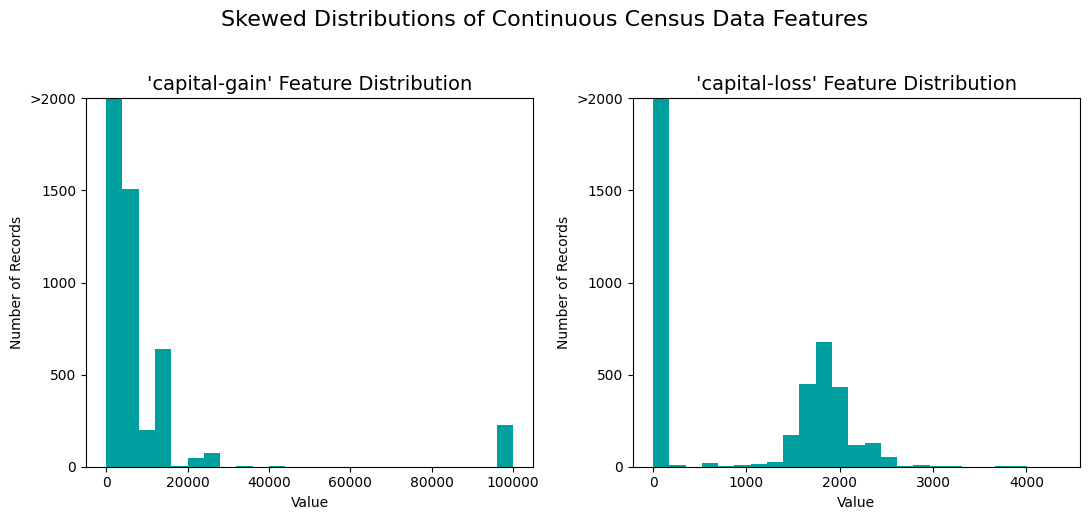

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

C:\Users\kewi\Desktop\egFWD\proj1\cd0025-supervised-learning-master\starter\visuals.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


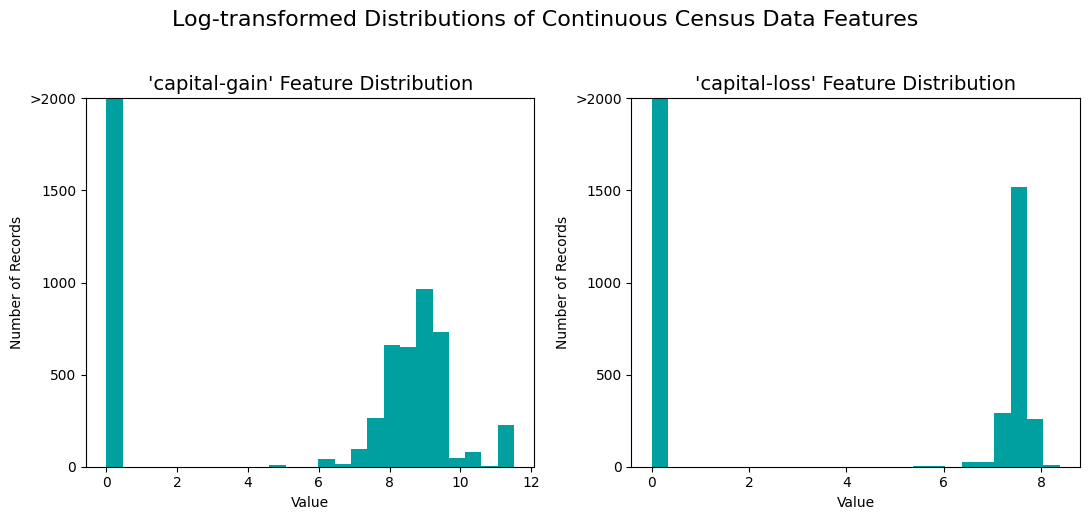

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [6]:
# TODO: One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# TODO: Encode the 'income_raw' data to numerical values
income = income_raw.map({'<=50K':0, '>50K':1})

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
# print(encoded)

103 total features after one-hot encoding.


In [7]:
features_final.head()

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,0.301370,0.800000,0.667492,0.0,0.397959,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.452055,0.800000,0.000000,0.0,0.122449,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,0.287671,0.533333,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.493151,0.400000,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0.150685,0.800000,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
income.head()

0    0
1    0
2    0
3    0
4    0
Name: income, dtype: int64

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [9]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Question 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

** Please note ** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

** HINT: ** 

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [10]:
'''
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''
# TODO: Calculate accuracy, precision and recall
TP = np.sum(income)
FP = income.count() - TP
TN = 0
FN = 0
accuracy = (TP+FN)/(TP+ TN+ FP + FN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
beta =0.5
fscore = (1+ beta**2)*( (precision*recall)/((beta**2) * precision + recall))

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))
print("Naive Predictor: [Precision score: {:.4f}, recall: {:.4f}]".format(precision, recall))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]
Naive Predictor: [Precision score: 0.2478, recall: 1.0000]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application TODODODODO
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

** HINT: **

Structure your answer in the same format as above^, with 4 parts for each of the three models you pick. Please include references with your answer.


**Answer: **

**Chosen Models:** Ensemble Methods(Random Forest), Logistic Regression and Support Vector Machines (SVM)
______________________________________________________________________________________________________________
**Random Forest:** 

**-Real world application:** 
- In Banking Industry, Random Forest can be used for Credit Card Fraud Detection.

**-Model strengths:** 
- Random forest gives a higher accuracy through cross validation.
- Missing data isn't a problem for Random Forests since model can handel them pretty well while providing good accuracy
- The model can work well with large data with big number of features

**-Model weaknesses:**
- If the data size or the number of features are relatively small, the model gives poor results.
- It's hard to interpret the meaning of the coefficients acting as a black box compared to other ML models like decision trees or logisitc regression
- Random forest consumes relatively big duration and space when fitting especially when the number of weak learners are big.

**-What makes the model good:**
- Random forest has a low chance of overfitting to our data.
- Using voting through the ensembling of many weak learner gives more confidence in the model since it mirrors how people, in real life, consult as many people with different mindsets as they can to reach a good decision. 
References: 
https://iq.opengenus.org/applications-of-random-forest/
https://www.rebellionresearch.com/what-are-the-disadvantages-of-random-forest
______________________________________________________________________________________________________________
**Logistic Regression:**

**-Real world application:**
- Hotel Booking is one such area where the model is used. A very famous booking service presented in a conference how they used logistic regression to infer information about their customers' behavior, such as knowing if a customer is more likely to change the date of a reserved trip.

**-Model strengths:**
- Simple, yet with competitive performance and good potential of solving so many problems.
- Relatively fast.
- Interpreting the coefficients meaning is doable one we understand the math behind it.

**-Model weaknesses:**
- The model shouldn't never be used if the number of features is larger than the number of observations (think about solving for an n variables using m equations where m<n). 
- It's not the best at obtaining complex relationships such as non-linear relationships. 

**-What makes the model good:**
- Logistic regression is good at binary classification problems such as ours. It's also the hello world of classification problems so it's good to use it as a baseline (on top of the base-line of a random guesser) and compare its performance to the other models.
References:
https://activewizards.com/blog/5-real-world-examples-of-logistic-regression-application
https://www.geeksforgeeks.org/advantages-and-disadvantages-of-logistic-regression/
https://www.spiceworks.com/tech/artificial-intelligence/articles/what-is-logistic-regression/
______________________________________________________________________________________________________________
**SVM:**

**-Real world application:**
- Face detection
- Images classification

**-Model strengths:**
- The model scales relatively well to data of high dimenstions.
- The kernel trick allows the model to tackle complex problems without the need for computing costly feature vectors.
- Performs well with unstructures and semi-structured data.

**-Model weaknesses:**
- The model takes relatively long time in training and predicting when trained on large dataset 
- Difficulty in interpreting the model (black box)

**-What makes the model good:**
- If the relation we're trying to model is non-linear, SVMs can obtain it easily using the kernel trick. 

References:
https://data-flair.training/blogs/applications-of-svm/
https://statinfer.com/204-6-8-svm-advantages-disadvantages-applications/
https://datamites.com/blog/support-vector-machine-algorithm-svm-understanding-kernel-trick/

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [11]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import accuracy_score, fbeta_score
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(predictions_train, y_train[:len(predictions_train)])
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] =  accuracy_score(predictions_test, y_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] =  fbeta_score(predictions_train, y_train[:len(predictions_train)], beta=0.5)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(predictions_test, y_test, beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

LogisticRegression trained on 36 samples.
LogisticRegression trained on 3617 samples.


C:\Users\kewi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression trained on 36177 samples.
SVC trained on 36 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.
RandomForestClassifier trained on 36 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.


C:\Users\kewi\Desktop\egFWD\proj1\cd0025-supervised-learning-master\starter\visuals.py:121: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  pl.tight_layout()


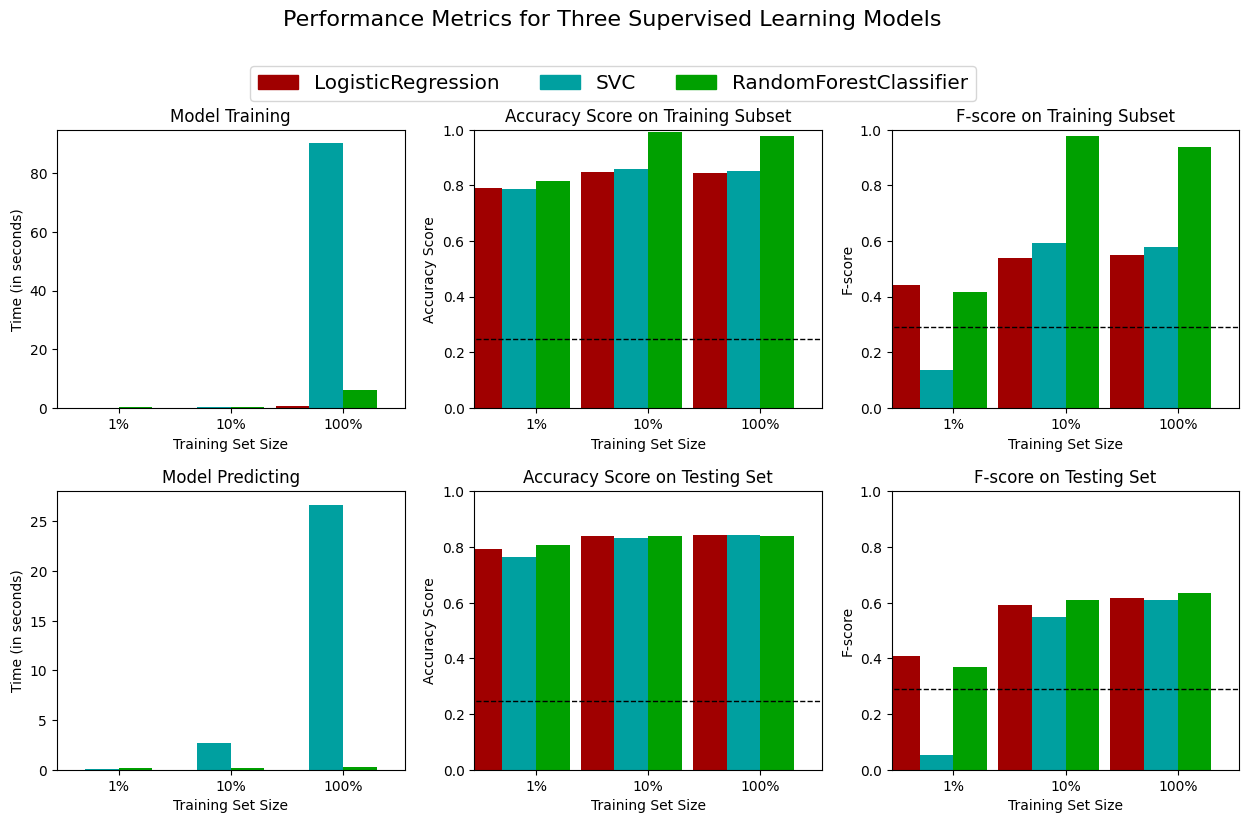

In [12]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
# TODO: Initialize the three models
clf_A = LogisticRegression(random_state = 2022)
clf_B = SVC(random_state =2022)
clf_C = RandomForestClassifier(random_state = 2022)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(X_train)
samples_10 = int(samples_100/10)
samples_1 = int(samples_10/100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model

* Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000. 

** HINT: ** 
Look at the graph at the bottom left from the cell above(the visualization created by `vs.evaluate(results, accuracy, fscore)`) and check the F score for the testing set when 100% of the training set is used. Which model has the highest score? Your answer should include discussion of the:
* metrics - F score on the testing when 100% of the training data is used, 
* prediction/training time
* the algorithm's suitability for the data.

**Answer: **
Random Forest Classifier seems the best candidate for this task. At 100% of the training data, the model achieved a slightly better F-score than what is achieved by the other models. The model also achieves the best accuracy of 90%+ on the training set, however it's similar to the rest of the models on the test set. Random Forest Classifier ranks second, being way faster than SVMs when it comes to the training and predicting time, and the difference of time between it and Logistic Regression isn't as substantial. The algorithm is suitable for the data and that's evident by how well it best fits the data at 10% and 100% capacityon of the training data and it's advantage in F-score on the testing data.


### Question 4 - Describing the Model in Layman's Terms 

* In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical jargon, such as describing equations.

** HINT: **

When explaining your model, if using external resources please include all citations.

**Answer: ** The model is easily explained by giving a real life analogy. Imagine you're having a problem deciding where to spend your next summer vacation. In order to find a good decision you decide to take the opinion of 20 friends of yours. Each friend has good expereince related to your problem but they may or may not have the same expereince. One might, for example, know the cheapest resorts. One might know what are the best destinations. One might advise you on the transport and how to spend time. You gather those 20 friends in a room and make them vote on a list of resorts you gathered on the internet if it's good or not. if the majority of your friends deem an option good then it's probably good and vice verca. 
In ML terms, your friends are the weak learner. Gathering your friends in one place and making them vote to decide on something is what random forests do with weak learners. The thing your friends vote on (the goal) is the independent variable we're trying to predict. The list of resorts you find on the internet is the testing set. One difference between the random forest and your friends analogy is that we teach the weak learners using the training set, so they aren't already expereinced like the case with the friends. 

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [13]:
# I tried RandomizedSearchCV becuase GridSearchCV with random forest takes too long 
# so i will use this to pick suitable ranges for grid search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

clf = RandomForestClassifier(random_state = 2022)

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}

parameters = {
    'n_estimators': [10,30,50,70,90,110,130,150],#8
    'criterion': ['gini', 'entropy', 'log_loss'],#3
    'max_depth': [10, 30, 50,  70, 90, 110], #6
    'min_samples_split': [2,8,32,64,128,256], #6
    'min_samples_leaf': [1,5,10,50,100], #5
    'max_features': ['sqrt', 'log2'], #2
    'bootstrap': [True, False],
#     'oob_score':[True, False],
             }

#2:10
# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
rand_obj = RandomizedSearchCV(clf, param_distributions=parameters, scoring=scorer, n_iter=100)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
start = time()
rand_fit = rand_obj.fit(X_train, y_train)
end = time()
print("time taken: {:.4f}s".format(end-start))
# Get the estimator
best_clf = rand_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

time taken: 1182.8283s
Unoptimized model
------
Accuracy score on testing data: 0.8399
F-score on testing data: 0.6756

Optimized Model
------
Final accuracy score on the testing data: 0.8608
Final F-score on the testing data: 0.7340


In [14]:
display(best_clf)
display(rand_obj.best_params_)
display(pd.DataFrame(rand_obj.cv_results_).sort_values('rank_test_score')[:50])
display(pd.DataFrame(rand_obj.cv_results_).sort_values('rank_test_score')[50:])
#based on the results belowe, we optimize the GridSearchCV parameters to minimize the size of the grid and compute results more
#efficiently

RandomForestClassifier(bootstrap=False, criterion='log_loss', max_depth=30,
                       max_features='log2', min_samples_split=64,
                       n_estimators=150, random_state=2022)

{'n_estimators': 150,
 'min_samples_split': 64,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 30,
 'criterion': 'log_loss',
 'bootstrap': False}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
25,5.580639,0.514146,0.246816,0.081709,150,64,1,log2,30,log_loss,False,"{'n_estimators': 150, 'min_samples_split': 64,...",0.739765,0.744012,0.739633,0.730245,0.742751,0.739281,0.004825,1
10,3.155281,0.349696,0.181322,0.100681,90,128,1,sqrt,90,entropy,True,"{'n_estimators': 90, 'min_samples_split': 128,...",0.735869,0.745745,0.736607,0.732667,0.741769,0.738532,0.004641,2
38,2.442872,0.527456,0.088967,0.034599,50,128,1,sqrt,30,entropy,False,"{'n_estimators': 50, 'min_samples_split': 128,...",0.735945,0.742846,0.740011,0.733740,0.739847,0.738478,0.003230,3
6,2.844255,0.427073,0.136870,0.066551,90,128,1,sqrt,70,gini,True,"{'n_estimators': 90, 'min_samples_split': 128,...",0.739517,0.745083,0.734211,0.732385,0.740514,0.738342,0.004563,4
35,3.209400,0.578381,0.129651,0.049373,90,64,1,sqrt,110,log_loss,True,"{'n_estimators': 90, 'min_samples_split': 64, ...",0.737942,0.742835,0.735370,0.733053,0.738206,0.737481,0.003270,5
51,3.845332,0.496832,0.202476,0.066278,110,64,1,sqrt,70,gini,True,"{'n_estimators': 110, 'min_samples_split': 64,...",0.739348,0.738277,0.737179,0.734828,0.737184,0.737363,0.001501,6
19,1.363531,0.242496,0.075417,0.025862,50,128,1,sqrt,110,log_loss,True,"{'n_estimators': 50, 'min_samples_split': 128,...",0.732660,0.746143,0.736911,0.728226,0.742534,0.737295,0.006475,7
68,3.333233,0.610485,0.145813,0.053599,90,2,5,sqrt,50,log_loss,True,"{'n_estimators': 90, 'min_samples_split': 2, '...",0.734562,0.743270,0.732350,0.729167,0.745367,0.736943,0.006297,8
77,1.831911,0.352291,0.083769,0.032580,50,128,1,sqrt,70,gini,True,"{'n_estimators': 50, 'min_samples_split': 128,...",0.735235,0.744667,0.734482,0.729279,0.739489,0.736630,0.005165,9
98,5.941703,0.098045,0.199872,0.077864,130,64,5,sqrt,70,gini,False,"{'n_estimators': 130, 'min_samples_split': 64,...",0.730587,0.739940,0.734713,0.731297,0.741702,0.735648,0.004483,10


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
91,1.715428,0.460979,0.075382,0.025769,50,256,50,sqrt,90,log_loss,False,"{'n_estimators': 50, 'min_samples_split': 256,...",0.714286,0.737148,0.715461,0.716871,0.722117,0.721176,0.008422,51
71,2.428506,0.640032,0.092345,0.034985,70,64,50,sqrt,70,entropy,False,"{'n_estimators': 70, 'min_samples_split': 64, ...",0.716184,0.734987,0.716871,0.714981,0.721104,0.720825,0.007375,52
7,2.227022,0.567909,0.077455,0.028107,70,64,50,sqrt,110,log_loss,False,"{'n_estimators': 70, 'min_samples_split': 64, ...",0.716184,0.734987,0.716871,0.714981,0.721104,0.720825,0.007375,52
86,0.328927,0.005597,0.031708,0.000393,10,64,10,log2,90,gini,True,"{'n_estimators': 10, 'min_samples_split': 64, ...",0.715336,0.731883,0.714386,0.715638,0.720604,0.719569,0.006526,54
57,1.662871,0.760353,0.097124,0.041659,30,8,50,sqrt,110,log_loss,True,"{'n_estimators': 30, 'min_samples_split': 8, '...",0.713276,0.732537,0.714581,0.713983,0.722848,0.719445,0.007410,55
39,1.347803,0.328271,0.079988,0.031938,70,64,1,log2,10,gini,False,"{'n_estimators': 70, 'min_samples_split': 64, ...",0.711079,0.728547,0.718454,0.721124,0.714991,0.718839,0.005910,56
37,2.267128,0.305058,0.194870,0.110025,110,64,1,log2,10,log_loss,False,"{'n_estimators': 110, 'min_samples_split': 64,...",0.706719,0.722873,0.723401,0.709647,0.721067,0.716742,0.007091,57
52,1.185406,0.444957,0.064053,0.046086,30,128,100,sqrt,50,log_loss,False,"{'n_estimators': 30, 'min_samples_split': 128,...",0.704867,0.728371,0.708170,0.712885,0.719658,0.714790,0.008415,58
15,6.016581,0.252443,0.246257,0.002795,150,8,1,log2,50,log_loss,True,"{'n_estimators': 150, 'min_samples_split': 8, ...",0.712384,0.714557,0.713921,0.702928,0.725303,0.713819,0.007115,59
5,0.159337,0.006251,0.009374,0.007654,10,128,100,sqrt,10,entropy,True,"{'n_estimators': 10, 'min_samples_split': 128,...",0.701090,0.721104,0.709848,0.716122,0.717402,0.713113,0.007022,60


In [15]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
# TODO: Initialize the classifier
clf = RandomForestClassifier()

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}

parameters = {
    'n_estimators': [50,100,150],
    'criterion': ['entropy', 'log_loss'],
    'min_samples_split': [2,8,64], 
             }

#2:10
# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, param_grid=parameters, scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
start = time()
grid_fit = grid_obj.fit(X_train, y_train)
end = time()
print("time taken: {:.4f}s".format(start-end))
# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

time taken: -881.1018s
Unoptimized model
------
Accuracy score on testing data: 0.8413
F-score on testing data: 0.6783

Optimized Model
------
Final accuracy score on the testing data: 0.8614
Final F-score on the testing data: 0.7325


### Question 5 - Final Model Evaluation

* What is your optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  

**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |   Naive predictor |
| :------------: | :---------------: | :-------------: | :-------------:   |
| Accuracy Score |       0.8413      |      0.8614     |     0.2478        |
| F-score        |       0.6783      |      0.7325     |     0.2917        |


**Answer: **
- The optimized model's accuracy and F-score are in the table.
- These scores are better than the unoptimized model. 
- I added the results of the naive predictor to the table. The results are clearly better than the naive predictor.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

**Answer:** 
I think the most influential features are : native-country, capital-gain, occupation, workclass, age
I'd rank them as:
1. occupation
2. captial-gain
3. workclass
4. age
5. native-country

I think that Occupation has a very strong connection with the income. Capital gain too. Workclass is similar to occupation, but it's not as strong of an indicator as occupation. Age is interesting because most times, to a certain age, the older someone is the more senior positions they have, the more money they make. Native country is a metric that can control how much money the person makes since differenct countries have differnt GDP, taxes, etc. 

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

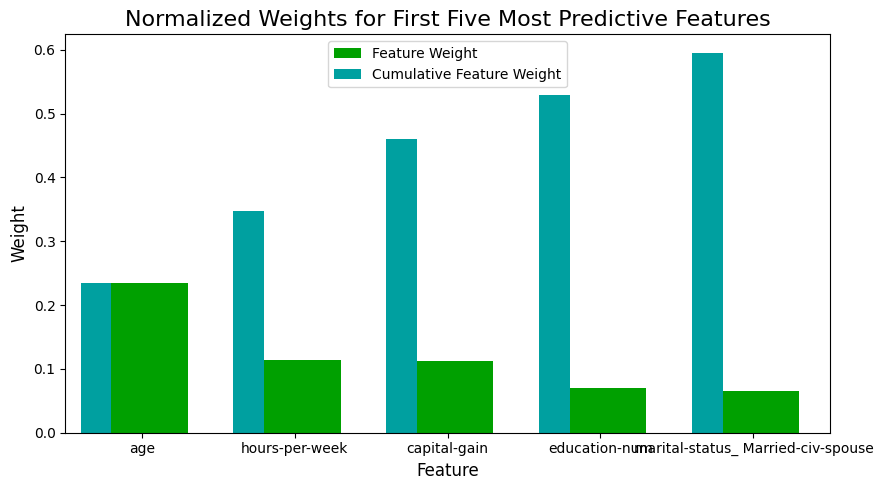

In [16]:
# TODO: Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import RandomForestClassifier


# TODO: Train the supervised model on the training set using .fit(X_train, y_train)
model = RandomForestClassifier().fit(X_train, y_train)

# TODO: Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
* How do these five features compare to the five features you discussed in **Question 6**?
* If you were close to the same answer, how does this visualization confirm your thoughts? 
* If you were not close, why do you think these features are more relevant?

**Answer:**
The ones I got right are:
1. age
2. capital gain
The ones I missed are:
1. hours per week
2. marital status
3. education-num

The visualization says that age is the most important feature. Capital gain is of great importance as well, but it's of less importance compared to age, which is the opposite of the ranking I had in mind. As for the other important features, my speculation is that maybe working less hours is higly correlated with being at a senior level that pays a lot. I think it's less likely that working long hours correlated with making a lot of money even at countries that have fair minimum wages. Marital status is probably influential since maybe it's a reverse (not inverse) correlation that people who are married already had massive income that lead them to decide to marry in the first place. Then we have education num which can be explainable by the tendancy of people with higher education to work in high paying jobs.


### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [17]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8614
F-score on testing data: 0.7325

Final Model trained on reduced data
------
Accuracy on testing data: 0.8471
F-score on testing data: 0.6985


### Question 8 - Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would you consider using the reduced data as your training set?

**Answer:**
- The model still performs reasonably well with only 0.02 decrease in accuracy and 0.04 decrease in F-score .
- it all depends. If I care more about accuracy and F-score then I can tolerate the high expense of training the model once for a long time in exchange for a slightly better performance. If that's not my concern then definitely I'd use the reduced dataset and save time and money for the slight decrease in performance.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.